In [1]:
import numpy as np
from sklearn.datasets import load_files
from sklearn.model_selection import train_test_split
from tensorflow.keras.preprocessing.text import Tokenizer
from tensorflow.keras.preprocessing.sequence import pad_sequences
from tensorflow.keras.models import Sequential
from tensorflow.keras.layers import Embedding, Bidirectional, LSTM, Dense, Dropout
from tensorflow.keras.utils import to_categorical
from tensorflow.keras.regularizers import l2
from sklearn.metrics import classification_report, confusion_matrix
import matplotlib.pyplot as plt
import seaborn as sns
import pickle
import pandas as pd


# Once data has finished processing, load data from folder structure
# text-data/
# ├─ advertisement/
# ├─ email/
# ├─ invoice/
# ....
data = load_files('../text-data', encoding='utf-8', decode_error='ignore')

X = data.data               
y = data.target             
class_names = data.target_names 

# split data for training and testing
X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.2, random_state=42)

In [2]:
# Tokenize
max_words = 20000
tokenizer = Tokenizer(
    num_words=max_words,
    filters='\'!"#$%&()*+,-./:;<=>?@[\\]^_`{|}~\t\n',
    lower=True
)
tokenizer.fit_on_texts(X_train)

X_train_seq = tokenizer.texts_to_sequences(X_train)
X_test_seq = tokenizer.texts_to_sequences(X_test)

# Pad sequences
max_len = 200
X_train_pad = pad_sequences(X_train_seq, maxlen=max_len, padding='post', truncating='post')
X_test_pad = pad_sequences(X_test_seq, maxlen=max_len, padding='post', truncating='post')

# One-hot encode labels
num_classes = len(class_names)
y_train_cat = to_categorical(y_train, num_classes=num_classes)
y_test_cat = to_categorical(y_test, num_classes=num_classes)

In [3]:
# Build the model
model = Sequential()
model.add(Embedding(input_dim=max_words, output_dim=128, embeddings_regularizer=l2(0.001)))
model.add(Bidirectional(LSTM(64, return_sequences=False, dropout=0.1, recurrent_dropout=0.1)))
model.add(Dropout(0.25))
model.add(Dense(num_classes, activation='softmax'))

model.compile(
    loss='categorical_crossentropy',
    optimizer='adam',
    metrics=['accuracy']
)
model.build(input_shape=(None, max_len))
model.summary()

# Train
history = model.fit(
    X_train_pad, y_train_cat,
    epochs=10,
    batch_size=32,
    validation_split=0.1,
    shuffle=True
)

# Evaluate
loss, acc = model.evaluate(X_test_pad, y_test_cat, verbose=1)
print("Test accuracy:", acc)

Model: "sequential"

┏━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━┓
┃ Layer (type)                    ┃ Output Shape           ┃       Param # ┃
┡━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━┩
│ embedding (Embedding)           │ (None, 200, 128)       │     2,560,000 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ bidirectional (Bidirectional)   │ (None, 128)            │        98,816 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dropout (Dropout)               │ (None, 128)            │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dense (Dense)                   │ (None, 16)             │         2,064 │
└─────────────────────────────────┴────────────────────────┴───────────────┘

 Total params: 2,660,880 (10.15 MB)

 Trainable params: 2,660,880 (10.15 MB)

 Non-trainable params: 0 (0.00 B)

Epoch 1/10
113/113 ━━━━━━━━━━━━━━━━━━━━ 14s 106ms/step - accuracy: 0.2006 - loss: 2.8248 - val_accuracy: 0.3100 - val_loss: 2.2308
Epoch 2/10
113/113 ━━━━━━━━━━━━━━━━━━━━ 12s 103ms/step - accuracy: 0.3961 - loss: 2.0570 - val_accuracy: 0.4675 - val_loss: 1.7929
Epoch 3/10
113/113 ━━━━━━━━━━━━━━━━━━━━ 12s 103ms/step - accuracy: 0.5178 - loss: 1.7438 - val_accuracy: 0.4975 - val_loss: 1.6540
Epoch 4/10
113/113 ━━━━━━━━━━━━━━━━━━━━ 12s 104ms/step - accuracy: 0.6014 - loss: 1.5178 - val_accuracy: 0.5950 - val_loss: 1.5221
Epoch 5/10
113/113 ━━━━━━━━━━━━━━━━━━━━ 12s 104ms/step - accuracy: 0.6722 - loss: 1.3451 - val_accuracy: 0.6375 - val_loss: 1.4988
Epoch 6/10
113/113 ━━━━━━━━━━━━━━━━━━━━ 12s 104ms/step - accuracy: 0.7419 - loss: 1.1891 - val_accuracy: 0.6600 - val_loss: 1.3822
Epoch 7/10
113/113 ━━━━━━━━━━━━━━━━━━━━ 11s 99ms/step - accuracy: 0.7842 - loss: 1.0890 - val_accuracy: 0.6900 - val_loss: 1.3771
Epoch 8/10
113/113 ━━━━━━━━━━━━━━━━━━━━ 10s 90ms/step - accuracy: 0.8200 - loss: 0.9

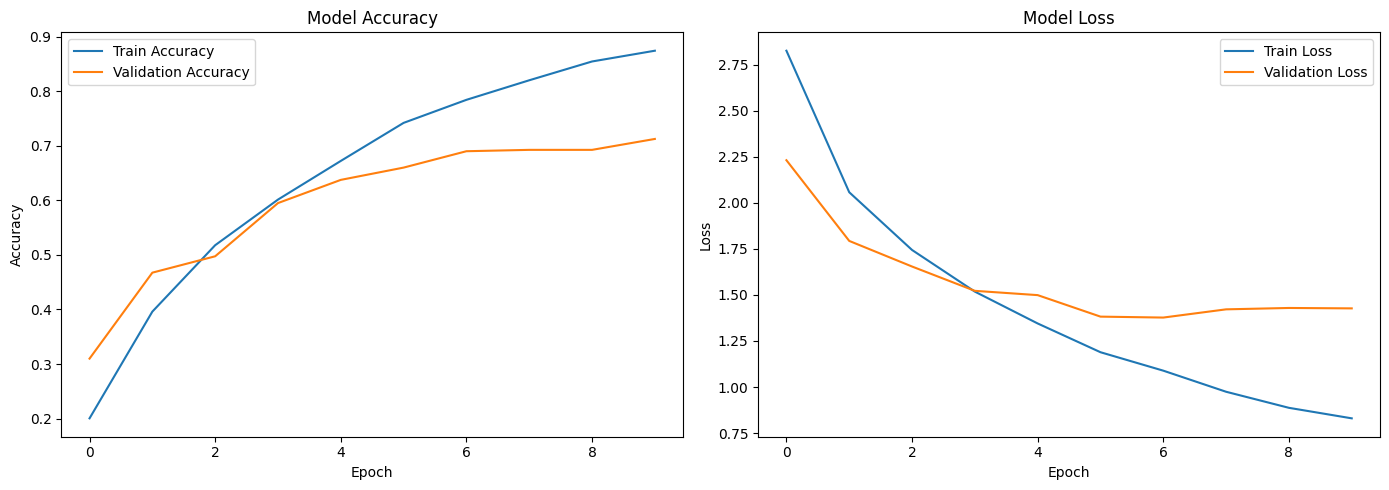

In [4]:
fig, axes = plt.subplots(1, 2, figsize=(14, 5))

# plot accuracy
axes[0].plot(history.history['accuracy'], label='Train Accuracy')
axes[0].plot(history.history['val_accuracy'], label='Validation Accuracy')
axes[0].set_title('Model Accuracy')
axes[0].set_xlabel('Epoch') 
axes[0].set_ylabel('Accuracy')
axes[0].legend()

# plot loss
axes[1].plot(history.history['loss'], label='Train Loss')
axes[1].plot(history.history['val_loss'], label='Validation Loss')
axes[1].set_title('Model Loss')
axes[1].set_xlabel('Epoch')
axes[1].set_ylabel('Loss')
axes[1].legend()

plt.tight_layout()
plt.savefig('training_history_RNN.png')
plt.show()

32/32 ━━━━━━━━━━━━━━━━━━━━ 1s 26ms/step


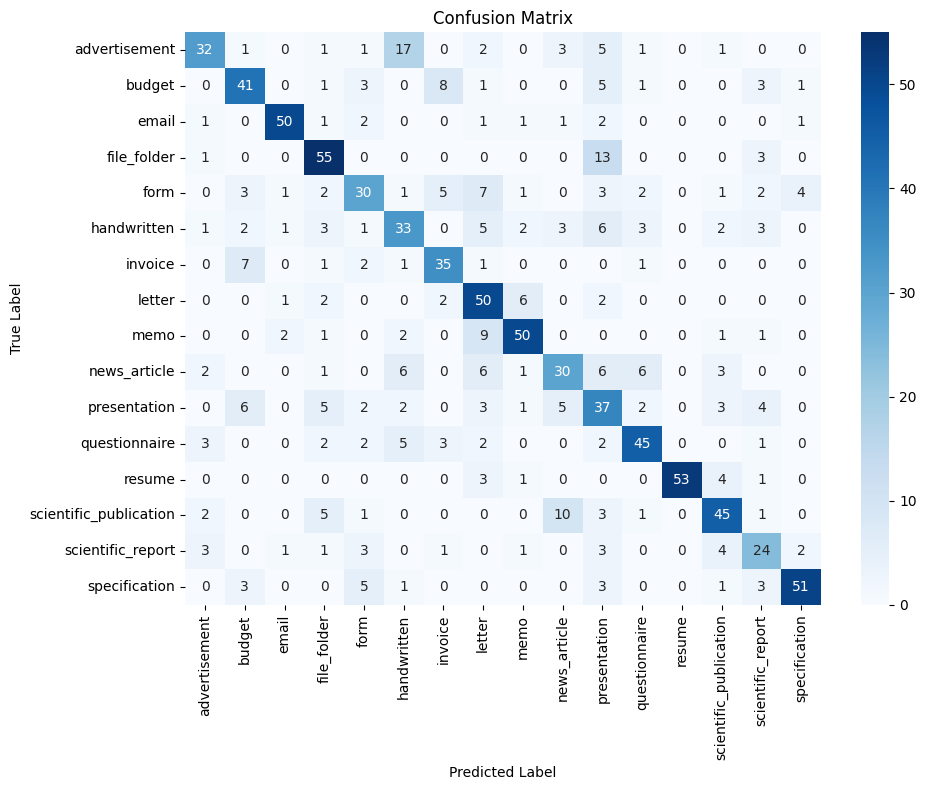

In [5]:
y_pred = model.predict(X_test_pad)
y_pred_classes = np.argmax(y_pred, axis=1)

# create confusion matrix
cm = confusion_matrix(y_test, y_pred_classes)
plt.figure(figsize=(10, 8))
sns.heatmap(cm, annot=True, fmt='d', cmap='Blues', xticklabels=class_names, yticklabels=class_names)
plt.title('Confusion Matrix')
plt.xlabel('Predicted Label')
plt.ylabel('True Label')
plt.tight_layout()
plt.savefig('confusion_matrix_RNN.png')
plt.show()

32/32 ━━━━━━━━━━━━━━━━━━━━ 1s 19ms/step


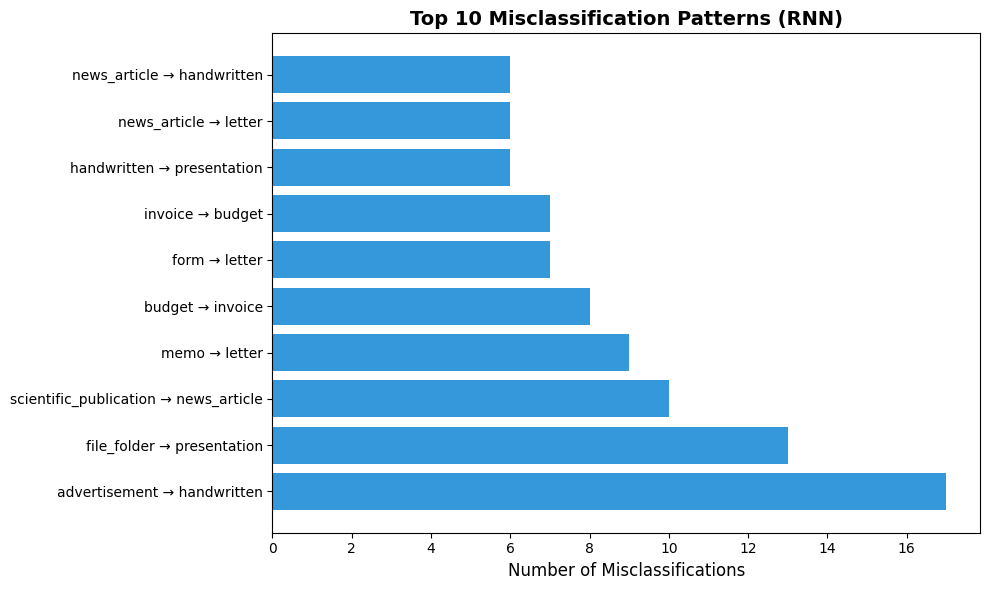

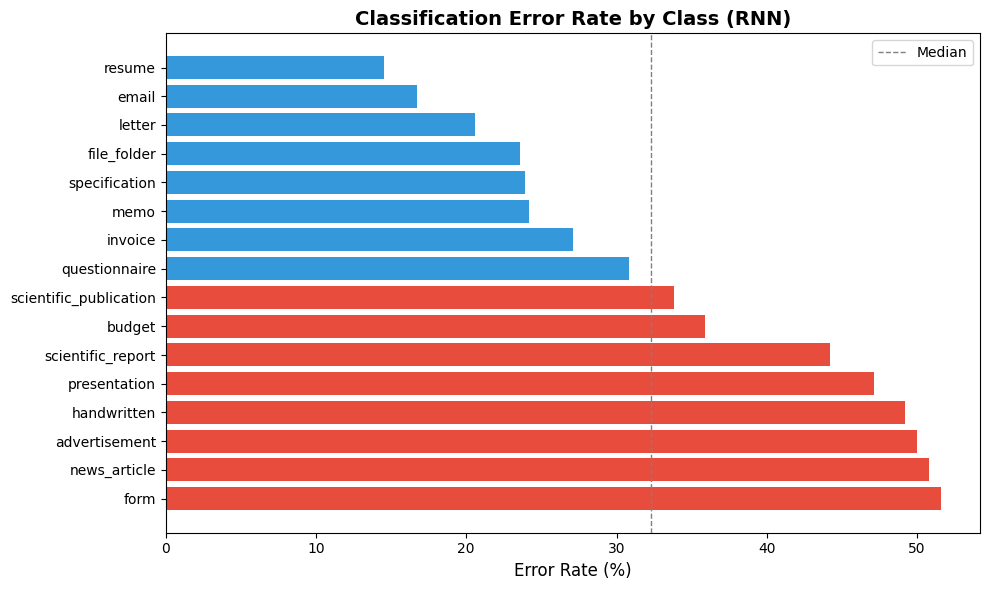

In [6]:
# Get predictions and misclassifications
y_pred = model.predict(X_test_pad)
y_pred_classes = np.argmax(y_pred, axis=1)
y_pred_probs = np.max(y_pred, axis=1)

misclassified_mask = y_test != y_pred_classes
misclassified_indices = np.where(misclassified_mask)[0]

misclass_df = pd.DataFrame({
    'true_label': [class_names[y_test[i]] for i in misclassified_indices],
    'predicted_label': [class_names[y_pred_classes[i]] for i in misclassified_indices]
})

misclass_pairs = misclass_df.groupby(['true_label', 'predicted_label']).size().reset_index(name='count')
misclass_pairs = misclass_pairs.sort_values('count', ascending=False)

plt.figure(figsize=(10, 6))
top_pairs = misclass_pairs.head(10)
plt.barh(range(len(top_pairs)), top_pairs['count'], color='#3498db')
plt.yticks(range(len(top_pairs)), 
           [f"{row['true_label']} → {row['predicted_label']}" 
            for _, row in top_pairs.iterrows()])
plt.xlabel('Number of Misclassifications', fontsize=12)
plt.title('Top 10 Misclassification Patterns (RNN)', fontsize=14, fontweight='bold')
plt.tight_layout()
plt.savefig('presentation_misclass_patterns_rnn.png', dpi=300, bbox_inches='tight')
plt.show()

error_by_class = pd.DataFrame({
    'Class': class_names,
    'Total': [np.sum(y_test == i) for i in range(len(class_names))],
    'Errors': [np.sum((y_test == i) & (y_pred_classes != i)) for i in range(len(class_names))],
})
error_by_class['Error Rate (%)'] = (error_by_class['Errors'] / error_by_class['Total'] * 100).round(1)
error_by_class = error_by_class.sort_values('Error Rate (%)', ascending=False)

plt.figure(figsize=(10, 6))
colors = ['#e74c3c' if x > error_by_class['Error Rate (%)'].median() else '#3498db' 
          for x in error_by_class['Error Rate (%)']]
plt.barh(error_by_class['Class'], error_by_class['Error Rate (%)'], color=colors)
plt.xlabel('Error Rate (%)', fontsize=12)
plt.title('Classification Error Rate by Class (RNN)', fontsize=14, fontweight='bold')
plt.axvline(error_by_class['Error Rate (%)'].median(), color='gray', linestyle='--', 
            linewidth=1, label='Median')
plt.legend()
plt.tight_layout()
plt.savefig('presentation_error_by_class_rnn.png', dpi=300, bbox_inches='tight')
plt.show()

In [7]:
model.save('rnn_classifier.keras')
import pickle
with open('tokenizer.pkl', 'wb') as f:
    pickle.dump(tokenizer, f)